In [1]:
required_packages <- c(
"caret",
"MASS",
"randomForest",
"e1071",
"ggplot2",
"dplyr",
"corrplot",
"nnet",
"naivebayes",
"MVN",
"mgcv",
"devtools"
)

# Function to install and load packages
install_and_load_packages <- function(packages) {
  cat("Checking and installing required packages...\n")
  
  for (package in packages) {
    if (!require(package, character.only = TRUE, quietly = TRUE)) {
      cat(sprintf("Installing package: %s\n", package))
      install.packages(package, dependencies = TRUE)
      if (!require(package, character.only = TRUE, quietly = TRUE)) {
        stop(sprintf("Package '%s' installation failed", package))
      }
    } else {
      cat(sprintf("Package '%s' is already installed and loaded\n", package))
    }
  }
  cat("\nAll required packages are installed and loaded!\n\n")
}

# Install and load all required packages
install_and_load_packages(required_packages)


Checking and installing required packages...
Package 'caret' is already installed and loaded
Package 'MASS' is already installed and loaded


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attachement du package : 'randomForest'


L'objet suivant est masqué depuis 'package:ggplot2':

    margin




Package 'randomForest' is already installed and loaded
Package 'e1071' is already installed and loaded
Package 'ggplot2' is already installed and loaded



Attachement du package : 'dplyr'


L'objet suivant est masqué depuis 'package:randomForest':

    combine


L'objet suivant est masqué depuis 'package:MASS':

    select


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union




Package 'dplyr' is already installed and loaded


corrplot 0.95 loaded



Package 'corrplot' is already installed and loaded
Package 'nnet' is already installed and loaded


naivebayes 1.0.0 loaded

For more information please visit: 

https://majkamichal.github.io/naivebayes/



Package 'naivebayes' is already installed and loaded
Package 'MVN' is already installed and loaded



Attachement du package : 'nlme'


L'objet suivant est masqué depuis 'package:dplyr':

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


Attachement du package : 'mgcv'


L'objet suivant est masqué depuis 'package:MVN':

    mvn


L'objet suivant est masqué depuis 'package:nnet':

    multinom




Package 'mgcv' is already installed and loaded
Package 'devtools' is already installed and loaded

All required packages are installed and loaded!



In [2]:
if (!requireNamespace("UBL", quietly = TRUE)) {
    devtools::install_github("paobranco/UBL")
} else {
    cat("Package 'UBL' is already installed.\n")
}

Package 'UBL' is already installed.


In [3]:
library(caret)
library(MASS)
library(randomForest)
library(naivebayes)
library(e1071)
library(ggplot2)
library(dplyr)
library(corrplot)
library(nnet)
library(MVN)
library(mgcv)
library(DMwR)
library(UBL)
library(devtools)

Le chargement a nécessité le package : grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Le chargement a nécessité le package : MBA

Le chargement a nécessité le package : gstat

Le chargement a nécessité le package : automap

Le chargement a nécessité le package : sp



In [4]:
# Read the data
data <- read.table("a24_clas_app.txt", header = TRUE, sep=" ")
data <- data[sample(nrow(data)),]
data$y <- as.factor(data$y)

# Make a copy of the original data for processing
data_cleaned <- data
data_cleaned_2 <- data

# Identify excluded variables (0-13 values)
excluded_vars <- c("X46", "X47", "X48", "X49", "X50") 
numeric_vars <- names(data_cleaned)[sapply(data_cleaned, is.numeric) & !(names(data_cleaned) %in% excluded_vars) & names(data_cleaned) != "y"]

# Outlier Removal
# ------------------
# Calculate skewness and IQR filtering for outliers on selected numeric variables only
for (var in numeric_vars) {
  Q1 <- quantile(data_cleaned[[var]], 0.25, na.rm = TRUE)
  Q3 <- quantile(data_cleaned[[var]], 0.75, na.rm = TRUE)
  IQR_val <- Q3 - Q1
  
  lower_bound <- Q1 - 1.5 * IQR_val
  upper_bound <- Q3 + 1.5 * IQR_val
  
  # Remove rows with outliers in any numeric variable
  data_cleaned <- data_cleaned[!(data_cleaned[[var]] < lower_bound | data_cleaned[[var]] > upper_bound), ]
}

# Calculate the ratio of rows deleted
cat("Rows deleted due to outliers:", (1 - nrow(data_cleaned) / nrow(data)) * 100, "%\n")

# Scaling
# ----------
# Apply scaling to numeric variables only
preprocess_params <- preProcess(data_cleaned[, numeric_vars], method = c("center", "scale"))
data_scaled <- data_cleaned
data_scaled[, numeric_vars] <- predict(preprocess_params, data_cleaned[, numeric_vars])

preprocess_params_2 <- preProcess(data_cleaned_2[, numeric_vars], method = c("center", "scale"))
data_scaled_2 <- data_cleaned_2
data_scaled_2[, numeric_vars] <- predict(preprocess_params_2, data_cleaned_2[, numeric_vars])

# Separate datasets with and without excluded variables
data_outlier <- data_scaled
data_outlier_excluded <- data_scaled %>% select(-all_of(excluded_vars))
data <- data_scaled_2
data_excluded <- data_scaled_2 %>% select(-all_of(excluded_vars))

Rows deleted due to outliers: 27.6 %


# weights:  156 (102 variable)
initial  value 283.441970 
iter  10 value 188.239679
iter  20 value 148.871644
iter  30 value 126.074036
iter  40 value 116.623995
iter  50 value 111.342691
iter  60 value 109.429823
iter  70 value 108.514542
iter  80 value 106.873883
iter  90 value 105.655770
iter 100 value 105.542727
final  value 105.542727 
stopped after 100 iterations
# weights:  156 (102 variable)
initial  value 283.441970 
iter  10 value 189.821155
iter  20 value 160.535369
iter  30 value 148.588758
iter  40 value 146.038928
iter  50 value 145.754982
iter  60 value 145.716287
iter  70 value 145.710814
iter  80 value 145.710100
iter  90 value 145.709976
iter  90 value 145.709974
iter  90 value 145.709974
final  value 145.709974 
converged
# weights:  156 (102 variable)
initial  value 283.441970 
iter  10 value 188.241305
iter  20 value 148.886626
iter  30 value 126.111437
iter  40 value 116.688651
iter  50 value 111.449884
iter  60 value 109.570721
iter  70 value 108.676523
iter  80 

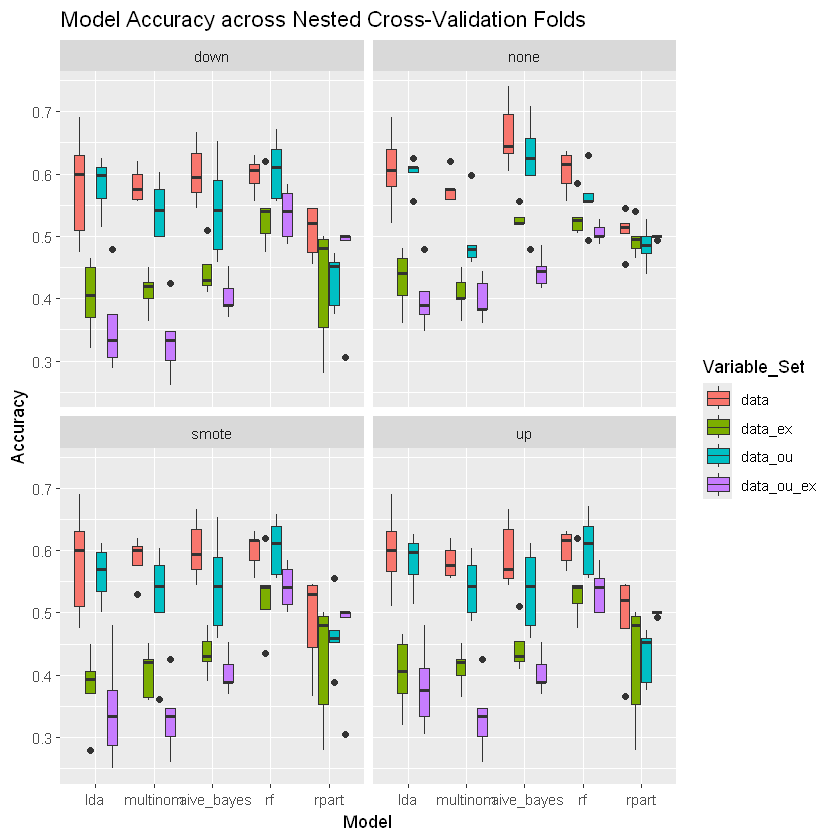

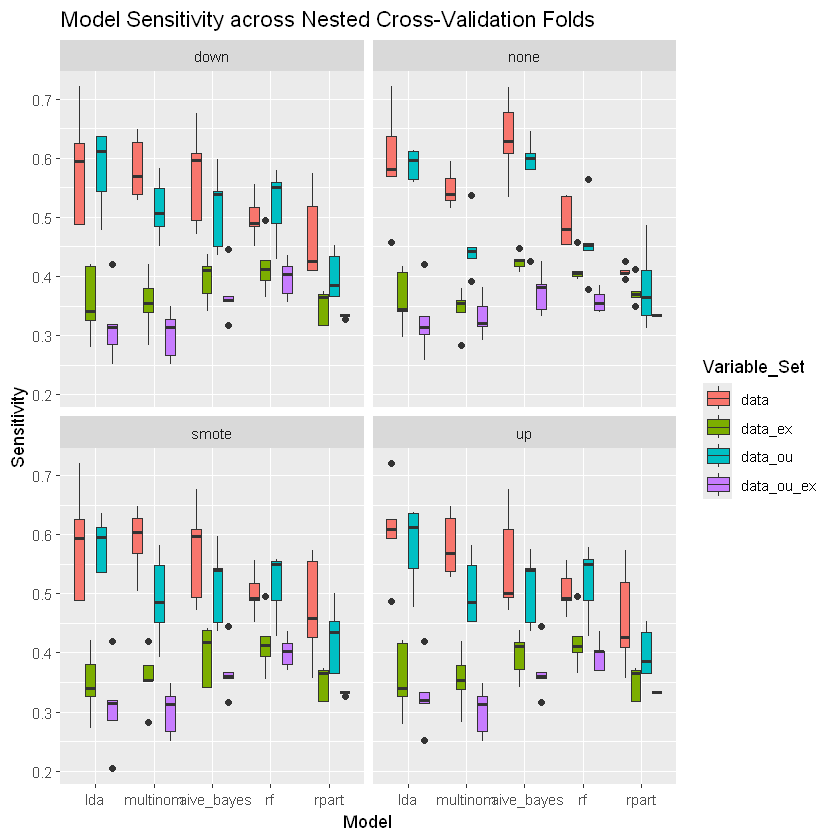

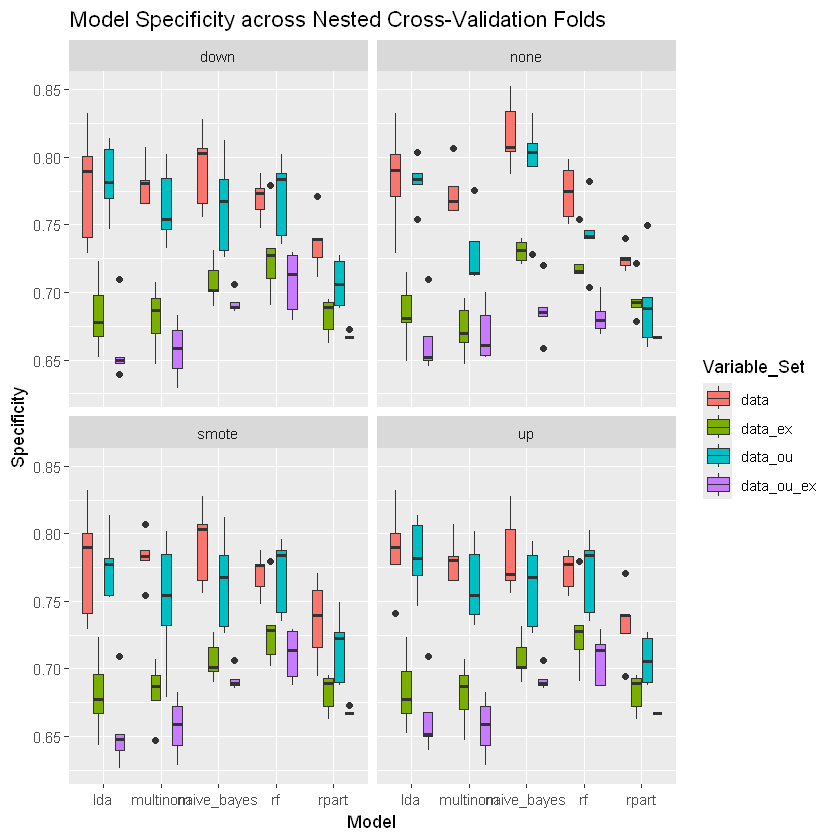

In [5]:
# Define outer and inner folds
set.seed(123)
outer_folds <- 5
inner_folds <- 5

classification_methods <- c("multinom", "naive_bayes", "lda", "rpart", "rf")

evaluate_model <- function(model, test_data, true_labels) {
  predictions <- predict(model, newdata = test_data)
  
  levels <- levels(true_labels)
  metrics <- multiClassSummary(data.frame(pred = predictions, obs = true_labels), lev = levels)
  
  return(list(
    Accuracy = metrics["Accuracy"],
    Sensitivity = metrics["Mean_Sensitivity"],
    Specificity = metrics["Mean_Specificity"]
  ))
}

# Function to apply sampling techniques
sample_data <- function(data, method = "none") {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

sampling_methods <- c("none", "up", "down", "smote") # Add your sampling methods here

results <- data.frame(Model = character(), Variable_Set = character(), Sampling_Method = character(), Fold = integer(),
                      Accuracy = numeric(), Sensitivity = numeric(), Specificity = numeric(), F1 = numeric(), row.names = NULL)

for (method in classification_methods) {
  for (variable_set in c("data", "data_ex", "data_ou", "data_ou_ex")) {
    
    data_set <- switch(variable_set,
                       "data" = data,
                       "data_ex" = data_excluded,
                       "data_ou" = data_outlier,
                       "data_ou_ex" = data_outlier_excluded)
    
    for (outer_fold in 1:outer_folds) {
      outer_train_index <- createFolds(data_set$y, k = outer_folds, list = TRUE, returnTrain = TRUE)[[outer_fold]]
      outer_train_data <- data_set[outer_train_index, ]
      outer_test_data <- data_set[-outer_train_index, ]
      
      best_inner_model <- NULL
      best_inner_accuracy <- 0
      
      for (sampling_method in sampling_methods) {
        sampled_outer_train_data <- sample_data(outer_train_data, method = sampling_method)
        
        for (inner_fold in 1:inner_folds) {
          inner_train_index <- createFolds(sampled_outer_train_data$y, k = inner_folds, list = TRUE, returnTrain = TRUE)[[inner_fold]]
          inner_train_data <- sampled_outer_train_data[inner_train_index, ]
          inner_val_data <- sampled_outer_train_data[-inner_train_index, ]
          
          model <- train(y ~ ., data = inner_train_data, method = method, trControl = trainControl(method = "cv", number = inner_folds), metric = "Accuracy")
          
          val_pred <- predict(model, newdata = inner_val_data)
          val_accuracy <- mean(val_pred == inner_val_data$y)
          
          if (val_accuracy > best_inner_accuracy) {
            best_inner_model <- model
            best_inner_accuracy <- val_accuracy
          }
        }
        
        outer_metrics <- evaluate_model(best_inner_model, outer_test_data, outer_test_data$y)
        
        results <- rbind(results, data.frame(Model = method, Variable_Set = variable_set, Sampling_Method = sampling_method, Fold = outer_fold,
                                             Accuracy = outer_metrics$Accuracy,
                                             Sensitivity = outer_metrics$Sensitivity,
                                             Specificity = outer_metrics$Specificity, row.names = NULL))
      }
    }
  }
}

# Plot results
ggplot(results, aes(x = Model, y = Accuracy, fill = Variable_Set)) +
  geom_boxplot() +
  facet_wrap(~ Sampling_Method) +
  labs(title = "Model Accuracy across Nested Cross-Validation Folds",
       x = "Model", y = "Accuracy")

ggplot(results, aes(x = Model, y = Sensitivity, fill = Variable_Set)) +
  geom_boxplot() +
  facet_wrap(~ Sampling_Method) +
  labs(title = "Model Sensitivity across Nested Cross-Validation Folds",
       x = "Model", y = "Sensitivity")

ggplot(results, aes(x = Model, y = Specificity, fill = Variable_Set)) +
  geom_boxplot() +
  facet_wrap(~ Sampling_Method) +
  labs(title = "Model Specificity across Nested Cross-Validation Folds",
       x = "Model", y = "Specificity")


In [6]:
results %>%
    group_by(Model, Variable_Set, Sampling_Method) %>%
    summarise(Accuracy = mean(Accuracy), Sensitivity = mean(Sensitivity), Specificity = mean(Specificity), .groups = 'drop') %>%
    arrange(desc(Accuracy))

Model,Variable_Set,Sampling_Method,Accuracy,Sensitivity,Specificity
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
naive_bayes,data,none,0.6634533,0.6334714,0.8171081
naive_bayes,data_ou,none,0.6135084,0.5718595,0.7935905
rf,data_ou,down,0.6076865,0.5209079,0.7703159
rf,data_ou,up,0.6076865,0.5209079,0.7703159
lda,data,none,0.6072121,0.5929271,0.7847688
rf,data_ou,smote,0.6049467,0.5161460,0.7689825
rf,data,none,0.6044478,0.4918351,0.7739723
rf,data,up,0.6044478,0.5046018,0.7727398
naive_bayes,data,down,0.6017888,0.5691370,0.7918874


until here we good

In [ ]:
# Fit the GAM model
data_gam <- data
data_gam[, excluded_vars] <- lapply(data_gam[, excluded_vars], as.factor)
preprocess_params_gam <- preProcess(data_gam[, numeric_vars], method = c("center", "scale"))
data_scaled_gam <- data_gam
data_scaled_gam[, numeric_vars] <- predict(preprocess_params_gam, data_gam[, numeric_vars])
print(head(data_scaled_gam))
continuous_vars <- paste0("s(X", 1:45, ")", collapse = " + ")
categorical_vars <- paste0("X", 46:50, collapse = " + ")
formula_string <- paste("y ~", continuous_vars, "+", categorical_vars)
model_formula <- as.formula(formula_string)
print(model_formula)

          X1           X2         X3         X4          X5         X6
1  0.1520951 -0.001077043  1.3232418  0.4829507  1.18447294  0.3128938
2  1.4828231 -1.320965483  0.8605130 -1.5410116 -1.19194583  1.0559602
3  1.6973454  1.575098487 -0.9227483  0.8383256 -0.71254470 -0.2796727
4 -1.1266522  1.213395380 -1.6323412  1.3704219 -0.77110979  0.5366186
5  0.7427705  0.319138772 -1.4308311 -0.7153544 -1.43298490 -1.2511355
6  1.0272638 -1.549598214 -1.3811201 -0.1612517  0.06608898  0.3763517
          X7         X8         X9        X10         X11        X12
1 -1.0309908 -1.1270022  1.0249860  1.4966017  0.11115773  0.8332604
2 -0.9621786  1.0931273  1.2423460 -0.2570111  0.12281814  0.4889229
3 -0.9251125 -0.5612810 -0.8580621  0.6826289 -1.20773705 -0.8165060
4  1.6303239  0.4889026  0.4843326 -1.2531756  0.80254853  1.2836441
5 -0.3360766  0.1892026  1.5472019  0.4840599 -0.03292476 -1.1545984
6  0.7836426  0.3381814 -0.3515586 -0.3020698 -0.33811617  0.8372291
          X13       

In [ ]:
# Define outer and inner folds
outer_folds <- 5
inner_folds <- 3

evaluate_gam_model <- function(model, test_data, true_labels) {
    predictions <- predict(model, newdata = test_data, type = "response")
    predicted_classes <- apply(predictions, 1, which.max)
    levels <- levels(true_labels)
    predicted_classes <- levels[predicted_classes]
    
    accuracy <- mean(predicted_classes == true_labels)
    return(accuracy)
}

results_gam <- data.frame(Fold = integer(), Accuracy = numeric(), row.names = NULL)

for (outer_fold in 1:outer_folds) {
    outer_train_index <- createFolds(data_scaled_gam$y, k = outer_folds, list = TRUE, returnTrain = TRUE)[[outer_fold]]
    outer_train_data <- data_scaled_gam[outer_train_index, ]
    outer_test_data <- data_scaled_gam[-outer_train_index, ]
    
    best_inner_model <- NULL
    best_inner_accuracy <- 0
    
    for (inner_fold in 1:inner_folds) {
        inner_train_index <- createFolds(outer_train_data$y, k = inner_folds, list = TRUE, returnTrain = TRUE)[[inner_fold]]
        inner_train_data <- outer_train_data[inner_train_index, ]
        inner_val_data <- outer_train_data[-inner_train_index, ]
        
        gam_model <- gam(model_formula, family = multinom(K = 3), data = inner_train_data)
        
        val_accuracy <- evaluate_gam_model(gam_model, inner_val_data, inner_val_data$y)
        
        if (val_accuracy > best_inner_accuracy) {
            best_inner_model <- gam_model
            best_inner_accuracy <- val_accuracy
        }
    }
    
    outer_accuracy <- evaluate_gam_model(best_inner_model, outer_test_data, outer_test_data$y)
    
    results_gam <- rbind(results_gam, data.frame(Fold = outer_fold, Accuracy = outer_accuracy, row.names = NULL))
}

row.names(results_gam) <- NULL


# Plot results
ggplot(results_gam, aes(x = factor(Fold), y = Accuracy)) +
    geom_boxplot() +
    labs(title = "GAM Model Accuracy across Nested Cross-Validation Folds",
         x = "Fold", y = "Accuracy")


ERROR: Error in offset[[i]]: tentative de sélection de moins d'un élément dans integerOneIndex
